# Decision Tree Greedy Algorithm

## Read Data

In [336]:
# Read data
import pandas as pd
df=pd.read_csv('titanic.csv')

# Drop the unused variables
df=df.drop(['Name'], axis=1)

# df=df.head(20)

In [337]:
from patsy import dmatrices
# Create matrices
y, X= dmatrices('Survived ~ Age + Fare + Q("Siblings/Spouses Aboard") + Q("Parents/Children Aboard") + C(Pclass) + C(Sex)', df, return_type = 'dataframe')

In [338]:
#Remove intercept
X=X.iloc[:,1:]

In [339]:
X.head()

,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],Age,Fare,"Q(""Siblings/Spouses Aboard"")","Q(""Parents/Children Aboard"")"
0,0.0,1.0,1.0,22.0,7.2500,1.0,0.0
1,0.0,0.0,0.0,38.0,71.2833,1.0,0.0
2,0.0,1.0,0.0,26.0,7.9250,0.0,0.0
3,0.0,0.0,0.0,35.0,53.1000,1.0,0.0
4,0.0,1.0,1.0,35.0,8.0500,0.0,0.0


## Step 1: Gini Index

In [5]:
# The Gini index is the name of the cost function used to evaluate splits in the dataset.Could entropy too but Gini is more efficient
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [6]:
print(gini_index([[[1, 1], [1, 0]], [[1, 1], [1, 0]]], [0, 1]))
print(gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0, 1]))

0.5
0.0


## Step 2: Split Dataset

In [7]:
# Split based on a threshold
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [8]:
# We would test every single split and its gini in order to find best split
# So this greedy algorithm need many computations
# Use this we could find the split with minimum gini
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups=999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups=test_split(index, row[index], dataset)
            gini=gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
                print(f'index: {b_index}, value: {b_value}, b_score: {b_score}')
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [9]:
import numpy as np
dataset=np.array(pd.merge(X, y, right_index=True, left_index=True))

In [10]:
get_split(dataset)

index: 0, value: 0.0, b_score: 0.5
index: 0, value: 1.0, b_score: 0.4117647058823529
index: 1, value: 1.0, b_score: 0.36263736263736274
index: 2, value: 1.0, b_score: 0.2525252525252525


{'index': 2,
 'value': 1.0,
 'groups': ([array([ 0.    ,  0.    ,  0.    , 38.    , 71.2833,  1.    ,  0.    ,
           1.    ]),
   array([ 0.   ,  1.   ,  0.   , 26.   ,  7.925,  0.   ,  0.   ,  1.   ]),
   array([ 0. ,  0. ,  0. , 35. , 53.1,  1. ,  0. ,  1. ]),
   array([ 0.    ,  1.    ,  0.    , 27.    , 11.1333,  0.    ,  2.    ,
           1.    ]),
   array([ 1.    ,  0.    ,  0.    , 14.    , 30.0708,  1.    ,  0.    ,
           1.    ]),
   array([ 0. ,  1. ,  0. ,  4. , 16.7,  1. ,  1. ,  1. ]),
   array([ 0.  ,  0.  ,  0.  , 58.  , 26.55,  0.  ,  0.  ,  1.  ]),
   array([ 0.    ,  1.    ,  0.    , 14.    ,  7.8542,  0.    ,  0.    ,
           0.    ]),
   array([ 1.,  0.,  0., 55., 16.,  0.,  0.,  1.]),
   array([ 0.,  1.,  0., 31., 18.,  1.,  0.,  0.]),
   array([ 0.   ,  1.   ,  0.   , 22.   ,  7.225,  0.   ,  0.   ,  1.   ])],
  [array([ 0.  ,  1.  ,  1.  , 22.  ,  7.25,  1.  ,  0.  ,  0.  ]),
   array([ 0.  ,  1.  ,  1.  , 35.  ,  8.05,  0.  ,  0.  ,  0.  ]),
   ar

In [11]:
# index 2 (Sex: male) is the split with smallist gini, which split the group the most
# Let's check
# if column=1 (male), there is only 11% survied; when the column=0 (female), there is 82% survived
print(sum(dataset[dataset[:,2]==1][:,-1])/len(dataset[dataset[:,2]==1][:,-1]))
print(sum(dataset[dataset[:,2]==0][:,-1])/len(dataset[dataset[:,2]==0][:,-1]))

0.1111111111111111
0.8181818181818182


## Step 3: Build a Tree

In [12]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [13]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [14]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [15]:
tree=build_tree(dataset, 3, 5)

index: 0, value: 0.0, b_score: 0.5
index: 0, value: 1.0, b_score: 0.4117647058823529
index: 1, value: 1.0, b_score: 0.36263736263736274
index: 2, value: 1.0, b_score: 0.2525252525252525
index: 0, value: 0.0, b_score: 0.2975206611570247
index: 0, value: 1.0, b_score: 0.2828282828282828
index: 1, value: 1.0, b_score: 0.2424242424242424
index: 0, value: 0.0, b_score: 0.4444444444444444
index: 3, value: 27.0, b_score: 0.41666666666666663
index: 3, value: 14.0, b_score: 0.4
index: 3, value: 31.0, b_score: 0.26666666666666655
index: 0, value: 0.0, b_score: 0.19753086419753085
index: 0, value: 1.0, b_score: 0.0
index: 0, value: 0.0, b_score: 0.0


In [16]:
tree

{'index': 2,
 'value': 1.0,
 'left': {'index': 1,
  'value': 1.0,
  'left': 1.0,
  'right': {'index': 3, 'value': 31.0, 'left': 1.0, 'right': 0.0}},
 'right': {'index': 0,
  'value': 1.0,
  'left': {'index': 0, 'value': 0.0, 'left': 0.0, 'right': 0.0},
  'right': 1.0}}

In [17]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [18]:
print_tree(tree, 3)

   [X3 < 1.000]
    [X2 < 1.000]
     [1.0]
     [X4 < 31.000]
      [1.0]
      [0.0]
    [X1 < 1.000]
     [X1 < 0.000]
      [0.0]
      [0.0]
     [1.0]


# Decision Tree with Sklearn

In [69]:
# Read data
import pandas as pd
df=pd.read_csv('titanic.csv')

# Drop the unused variables
df=df.drop(['Name'], axis=1)

from patsy import dmatrices
# Create matrices
y, X= dmatrices('Survived ~ Age + Fare + Q("Siblings/Spouses Aboard") + Q("Parents/Children Aboard") + C(Pclass) + C(Sex)', df, return_type = 'dataframe')

#Remove intercept
X=X.iloc[:,1:]

In [70]:
#Let's split the data
from sklearn.model_selection import train_test_split
X_train, X_test,  y_train, y_test= train_test_split(X, y, train_size=0.9)

In [71]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=5)
clf = clf.fit(X_train, y_train)

[Text(145.87714285714287, 199.32, 'X[2] <= 0.5\ngini = 0.473\nsamples = 798\nvalue = [491, 307]'),
 Text(59.785714285714285, 163.07999999999998, 'X[1] <= 0.5\ngini = 0.364\nsamples = 276\nvalue = [66, 210]'),
 Text(19.13142857142857, 126.83999999999999, 'X[3] <= 2.5\ngini = 0.09\nsamples = 148\nvalue = [7, 141]'),
 Text(9.565714285714286, 90.6, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(28.697142857142858, 90.6, 'X[4] <= 26.125\ngini = 0.079\nsamples = 146\nvalue = [6, 140]'),
 Text(19.13142857142857, 54.359999999999985, 'X[3] <= 56.0\ngini = 0.219\nsamples = 48\nvalue = [6, 42]'),
 Text(9.565714285714286, 18.119999999999976, 'gini = 0.19\nsamples = 47\nvalue = [5, 42]'),
 Text(28.697142857142858, 18.119999999999976, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(38.26285714285714, 54.359999999999985, 'gini = 0.0\nsamples = 98\nvalue = [0, 98]'),
 Text(100.44, 126.83999999999999, 'X[4] <= 23.35\ngini = 0.497\nsamples = 128\nvalue = [59, 69]'),
 Text(76.52571428571429, 90.6, '

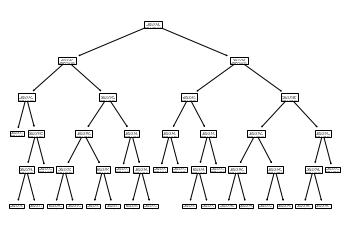

In [72]:
# Plot it
tree.plot_tree(clf) 

In [73]:
test_result=clf.predict(X_test)

In [74]:
import numpy as np
correct=0
for i in range(len(test_result)):
    if test_result[i]==np.array(y_test)[i]:
        correct+=1

In [75]:
print(f'accuracy is : {100*correct/len(test_result)}%')

accuracy is : 76.40449438202248%


# Let's Try the Soft Decision Tree in PyTorch

In [28]:
import torch
import torch.nn as nn
import torchvision

## Define SDT model

In [29]:
# Soft Deicison Function built by https://github.com/xuyxu/Soft-Decision-Tree/blob/master/SDT.py
class SDT(nn.Module):
    """Fast implementation of soft decision tree in PyTorch.
    Parameters
    ----------
    input_dim : int
      The number of input dimensions.
    output_dim : int
      The number of output dimensions. For example, for a multi-class
      classification problem with `K` classes, it is set to `K`.
    depth : int, default=5
      The depth of the soft decision tree. Since the soft decision tree is
      a full binary tree, setting `depth` to a large value will drastically
      increases the training and evaluating cost.
    lamda : float, default=1e-3
      The coefficient of the regularization term in the training loss. Please
      refer to the paper on the formulation of the regularization term.
    use_cuda : bool, default=False
      When set to `True`, use GPU to fit the model. Training a soft decision
      tree using CPU could be faster considering the inherent data forwarding
      process.
    
    Attributes
    ----------
    internal_node_num_ : int
      The number of internal nodes in the tree. Given the tree depth `d`, it
      equals to :math:`2^d - 1`.
    leaf_node_num_ : int
      The number of leaf nodes in the tree. Given the tree depth `d`, it equals
      to :math:`2^d`.
    penalty_list : list
      A list storing the layer-wise coefficients of the regularization term.
    inner_nodes : torch.nn.Sequential
      A container that simulates all internal nodes in the soft decision tree.
      The sigmoid activation function is concatenated to simulate the
      probabilistic routing mechanism.
    leaf_nodes : torch.nn.Linear
      A `nn.Linear` module that simulates all leaf nodes in the tree.
    """
    
    def __init__(
            self,
            input_dim,
            output_dim,
            depth,
            lamda=1e-3,
            use_cuda=False):
        super(SDT, self).__init__()
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        self.depth=depth
        self.lamda=lamda
        self.device=torch.device("cuda" if use_cuda else "cpu")
        
        self._validate_parameters()
        
        self.internal_node_num_=2**self.depth-1
        self.leaf_node_num_=2**self.depth
        
        """
        As per paper, We found that we achieved better test accuracy results
        when the strength of the penalty decayed exponentially with the depth d of the
        node in the tree so that it was proportional to 2−d
.
        """
        
        # Different penalty coefficients for nodes in different layers
        self.penalty_list = [
            self.lamda * (2 ** (-depth)) for depth in range(0, self.depth)
        ]
        
        # Initialize internal nodes and leaf nodes, the input dimension on
        # internal nodes is added by 1, serving as the bias.
        
        """
        As per paper, We use soft binary decision trees trained with mini-batch gradient descent, where
        each inner node i has a learned filter wi and a bias bi
        , and each leaf node `
        has a learned distribution Q`. At each inner node, the probability of taking the
        rightmost branch is:
        pi(x) = σ(xwi + bi)
        
        where x is the input to the model and σ is the sigmoid logistic function
        
        """
        
        self.inner_nodes = nn.Sequential(
            nn.Linear(self.input_dim + 1, self.internal_node_num_, bias=False),
            nn.Sigmoid(),
        )
        
        self.leaf_nodes = nn.Linear(self.leaf_node_num_,
                                    self.output_dim,
                                    bias=False)
        
    def forward(self, X, is_training_data=False):
        _mu, _penalty = self._forward(X)
        y_pred = self.leaf_nodes(_mu)

        # When `X` is the training data, the model also returns the penalty
        # to compute the training loss.
        if is_training_data:
            return y_pred, _penalty
        else:
            return y_pred
        
    def _forward(self, X):
        """Implementation on the data forwarding process."""

        # batch_size is the # of rows
        batch_size = X.size()[0]
        X = self._data_augment(X)
        
        path_prob = self.inner_nodes(X)
        path_prob = torch.unsqueeze(path_prob, dim=2)
        
        path_prob = torch.cat((path_prob, 1 - path_prob), dim=2)
        
        _mu = X.data.new(batch_size, 1, 1).fill_(1.0)
        _penalty = torch.tensor(0.0).to(self.device)
        
        # Iterate through internal odes in each layer to compute the final path
        # probabilities and the regularization term.
        begin_idx = 0
        end_idx = 1
        
        for layer_idx in range(0, self.depth):
            _path_prob = path_prob[:, begin_idx:end_idx, :]
            
            # Extract internal nodes in the current layer to compute the
            # regularization term
            _penalty = _penalty + self._cal_penalty(layer_idx, _mu, _path_prob)
            _mu = _mu.view(batch_size, -1, 1).repeat(1, 1, 2)
            
            """
            As per paper, This model can be used to give a predictive distribution over classes in two
            different ways, namely by using the distribution from the leaf with the greatest
            path probability or averaging the distributions over all the leaves, weighted by
            their respective path probabilities. If we take the predictive distribution from
            the leaf with the greatest path probability, the explanation for that prediction is
            simply the list of all the filters along the path from the route to the leaf together
            with the binary activation decisions
            """
            _mu = _mu * _path_prob  # update path probabilities
            
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (layer_idx + 1)
        
        mu = _mu.view(batch_size, self.leaf_node_num_)
        
        return mu, _penalty
    
    def _cal_penalty(self, layer_idx, _mu, _path_prob):
        """
        Compute the regularization term for internal nodes in different layers.
        """

        penalty = torch.tensor(0.0).to(self.device)

        batch_size = _mu.size()[0]
        _mu = _mu.view(batch_size, 2 ** layer_idx)
        _path_prob = _path_prob.view(batch_size, 2 ** (layer_idx + 1))
        
        # Get the regularization term
        for node in range(0, 2 ** (layer_idx + 1)):
            alpha = torch.sum(
                _path_prob[:, node] * _mu[:, node // 2], dim=0
            ) / torch.sum(_mu[:, node // 2], dim=0)

            coeff = self.penalty_list[layer_idx]

            penalty -= 0.5 * coeff * (torch.log(alpha) + torch.log(1 - alpha))

        return penalty
    
    def _data_augment(self, X):
        """Add a constant input `1` onto the front of each sample."""
        batch_size = X.size()[0]
        X = X.view(batch_size, -1)
        bias = torch.ones(batch_size, 1).to(self.device)
        X = torch.cat((bias, X), 1)

        return X
    
    def _validate_parameters(self):

        if not self.depth > 0:
            msg = ("The tree depth should be strictly positive, but got {}"
                   "instead.")
            raise ValueError(msg.format(self.depth))

        if not self.lamda >= 0:
            msg = (
                "The coefficient of the regularization term should not be"
                " negative, but got {} instead."
            )
            raise ValueError(msg.format(self.lamda)) 

# Process Data

In [84]:
# Read data
import pandas as pd
df=pd.read_csv('titanic.csv')

# Drop the unused variables
df=df.drop(['Name'], axis=1)

In [85]:
from patsy import dmatrices
# Create matrices
y, X= dmatrices('Survived ~ Age + Fare + Q("Siblings/Spouses Aboard") + Q("Parents/Children Aboard") + C(Pclass) + C(Sex)', df, return_type = 'dataframe')

#Remove intercept
X=X.iloc[:,1:]

In [86]:
X_continous=X[['Age', 'Fare', 'Q("Siblings/Spouses Aboard")', 'Q("Parents/Children Aboard")']]
X_class=X[['C(Pclass)[T.2]', 'C(Pclass)[T.3]', 'C(Sex)[T.male]']]

# Let standardize the data
from sklearn import preprocessing
standard_scaler=preprocessing.StandardScaler()
scaled_X = standard_scaler.fit_transform(X_continous)

df_array=np.hstack((np.array(X_class), scaled_X, np.array(y)))

In [87]:
#Let's split the data
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df_array, train_size=0.9)

In [88]:
tensor_train=torch.from_numpy(np.array(df_train)).float()
tensor_test=torch.from_numpy(np.array(df_test)).float()

In [89]:
tensor_train.size()

torch.Size([798, 8])

# Train the Model

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [38]:
def onehot_coding(target, device, output_dim):
    """Convert the class labels into one-hot encoded vectors."""
    target_onehot = torch.FloatTensor(target.size()[0], output_dim).to(device)
    target_onehot.data.zero_()
    target_onehot.scatter_(1, target.view(-1, 1), 1.0)
    return target_onehot

In [90]:
# Parameters
input_dim = 7          # the number of input dimensions
output_dim = 2         # the number of outputs (i.e., # classes on MNIST)
depth = 5              # tree depth
lamda = 1e-3           # coefficient of the regularization term
lr = 1e-3              # learning rate
weight_decaly = 5e-4   # weight decay
batch_size = 797       # batch size
epochs = 20            # the number of training epochs
log_interval = 100      # the number of batches to wait before printing logs
use_cuda = False       # whether to use GPU

In [91]:
# Model and Optimizer
tree = SDT(input_dim, output_dim, depth)

In [92]:
optimizer = torch.optim.Adam(tree.parameters(), lr=lr, weight_decay=weight_decaly)

In [93]:
best_testing_acc = 0.0
testing_acc_list = []
training_loss_list = []
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if use_cuda else "cpu")

In [94]:
for epoch in range(epochs):    
    tree.train()
    
    for batch_idx, dataset in enumerate(tensor_train):
        
        data=dataset[:-1].view(1,-1)
        target=dataset[-1:].to(torch.long)
        batch_size=data.size()[0]
        
        target_onehot=onehot_coding(target, device, output_dim)
        
        output, penalty=tree.forward(data, is_training_data=True)
        
        loss = criterion(output, target.view(-1))
        
        loss+=penalty
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print training status
        if batch_idx % log_interval == 0:
            pred = output.data.max(1)[1]
            correct = pred.eq(target.view(-1).data).sum()

            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f} |"
                " Correct: {:03d}/{:03d}"
            )
            print(msg.format(epoch, batch_idx, loss, correct, batch_size))
            training_loss_list.append(loss.cpu().data.numpy())
        
    # Evaluating
    tree.eval()
    correct = 0.

    for batch_idx, dataset in enumerate(tensor_test):

        data=dataset[:-1].view(1,-1)
        target=dataset[-1:].to(torch.long)
        batch_size=data.size()[0]

        output = F.softmax(tree.forward(data), dim=1)

        pred = output.data.max(1)[1]
        correct += pred.eq(target.view(-1).data).sum()

    accuracy = 100.0 * float(correct) / len(tensor_test)

    if accuracy > best_testing_acc:
        best_testing_acc = accuracy

    msg = (
        "\nEpoch: {:02d} | Testing Accuracy: {}/{} ({:.3f}%) |"
        " Historical Best: {:.3f}%\n"
    )
    print(
        msg.format(
            epoch, correct,
            len(tensor_test),
            accuracy,
            best_testing_acc
        )
    )
    testing_acc_list.append(accuracy)

Epoch: 00 | Batch: 000 | Loss: 0.70943 | Correct: 000/001
Epoch: 00 | Batch: 100 | Loss: 0.68963 | Correct: 001/001
Epoch: 00 | Batch: 200 | Loss: 0.65516 | Correct: 001/001
Epoch: 00 | Batch: 300 | Loss: 0.79931 | Correct: 000/001
Epoch: 00 | Batch: 400 | Loss: 0.80548 | Correct: 000/001
Epoch: 00 | Batch: 500 | Loss: 0.82915 | Correct: 000/001
Epoch: 00 | Batch: 600 | Loss: 0.83691 | Correct: 000/001
Epoch: 00 | Batch: 700 | Loss: 0.55794 | Correct: 001/001

Epoch: 00 | Testing Accuracy: 60.0/89 (67.416%) | Historical Best: 67.416%

Epoch: 01 | Batch: 000 | Loss: 0.89937 | Correct: 000/001
Epoch: 01 | Batch: 100 | Loss: 0.53603 | Correct: 001/001
Epoch: 01 | Batch: 200 | Loss: 0.53630 | Correct: 001/001
Epoch: 01 | Batch: 300 | Loss: 1.14811 | Correct: 000/001
Epoch: 01 | Batch: 400 | Loss: 0.97512 | Correct: 000/001
Epoch: 01 | Batch: 500 | Loss: 1.00899 | Correct: 000/001
Epoch: 01 | Batch: 600 | Loss: 0.97210 | Correct: 000/001
Epoch: 01 | Batch: 700 | Loss: 0.48596 | Correct: 001

Epoch: 15 | Batch: 200 | Loss: 0.29891 | Correct: 001/001
Epoch: 15 | Batch: 300 | Loss: 2.04405 | Correct: 000/001
Epoch: 15 | Batch: 400 | Loss: 0.44699 | Correct: 001/001
Epoch: 15 | Batch: 500 | Loss: 0.55171 | Correct: 001/001
Epoch: 15 | Batch: 600 | Loss: 0.93488 | Correct: 000/001
Epoch: 15 | Batch: 700 | Loss: 1.14714 | Correct: 000/001

Epoch: 15 | Testing Accuracy: 78.0/89 (87.640%) | Historical Best: 88.764%

Epoch: 16 | Batch: 000 | Loss: 0.52980 | Correct: 001/001
Epoch: 16 | Batch: 100 | Loss: 0.17322 | Correct: 001/001
Epoch: 16 | Batch: 200 | Loss: 0.29119 | Correct: 001/001
Epoch: 16 | Batch: 300 | Loss: 2.05592 | Correct: 000/001
Epoch: 16 | Batch: 400 | Loss: 0.44152 | Correct: 001/001
Epoch: 16 | Batch: 500 | Loss: 0.54728 | Correct: 001/001
Epoch: 16 | Batch: 600 | Loss: 0.90369 | Correct: 000/001
Epoch: 16 | Batch: 700 | Loss: 1.15797 | Correct: 000/001

Epoch: 16 | Testing Accuracy: 78.0/89 (87.640%) | Historical Best: 88.764%

Epoch: 17 | Batch: 000 | Loss: 0.5